<a href="https://colab.research.google.com/github/shenzeng1234/nanoindentation_clustering/blob/main/nanoindentation_clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1D Analysis

## Histogram


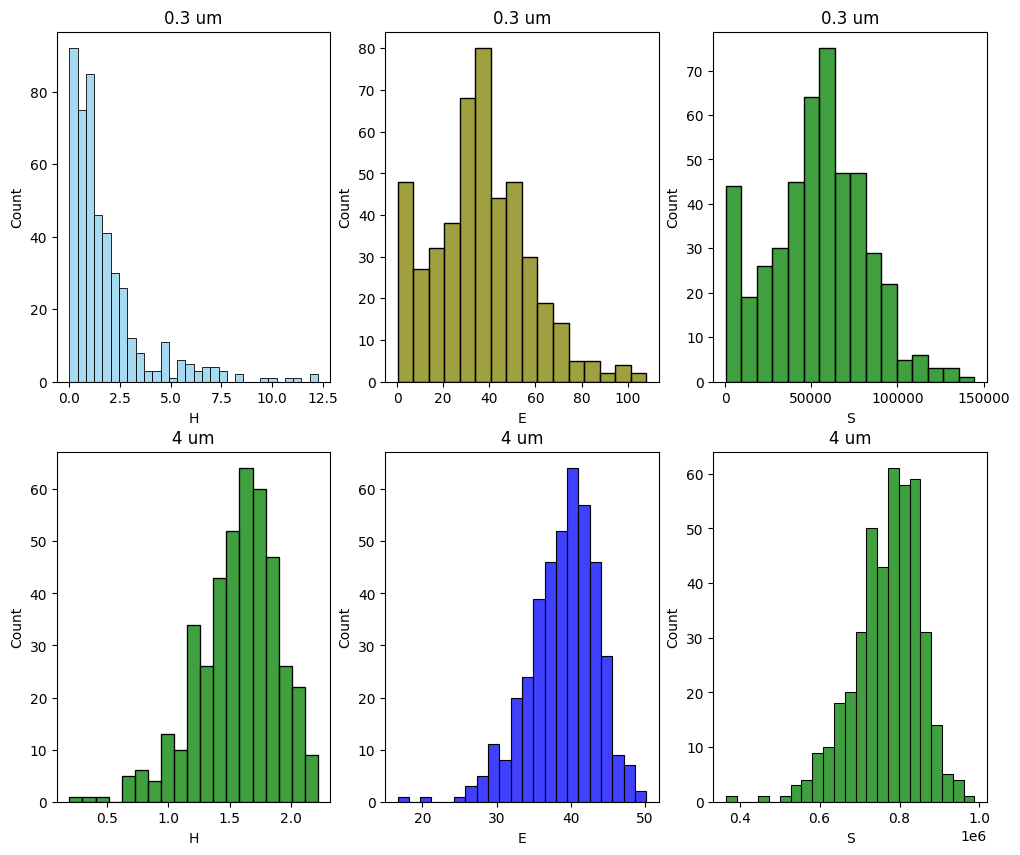

In [ ]:
#!pip install pandas-profiling
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#from pandas_profiling import ProfileReport

%matplotlib inline

#df_all = pd.read_excel("datasets_for_fig5.xlsx",sheet_name=["0.3 um","4 um"],index_col=None, header=None)
df_all = pd.read_excel("datasets_for_fig5_hes.xlsx",sheet_name=["0.3 um","4 um"])

df300 = df_all.get("0.3 um")
df4000 = df_all.get("4 um")

#0.3 um hardness, elasticity, stiffness
df300H, df300E, df300S,  = df300.H.to_numpy(), df300.E.to_numpy(), df300.S.to_numpy()

#4 um hardness, elasticity, stiffness
df4000H, df4000E, df4000S,  = df4000.H.to_numpy(), df4000.E.to_numpy(), df4000.S.to_numpy()

fig, axs = plt.subplots(2, 3, figsize=(12, 10))
#
sns.histplot(data=df300, x="H", color="skyblue", ax=axs[0,0]).set(title='0.3 um')
sns.histplot(data=df300, x="E", color="olive", ax=axs[0,1]).set(title='0.3 um')
sns.histplot(data=df300, x="S", color="green", ax=axs[0,2]).set(title='0.3 um')
sns.histplot(data=df4000, x="H", color="green", ax=axs[1,0]).set(title='4 um')
sns.histplot(data=df4000, x="E", color="blue", ax=axs[1,1]).set(title='4 um')
sns.histplot(data=df4000, x="S", color="green", ax=axs[1,2]).set(title='4 um')

#ProfileReport(df4)

#hardness + elasticity + stiffness
hes300 = np.hstack((df300H, df300E, df300S))
hes4000 = np.hstack((df4000H, df4000E,df4000S))

Distribution of Hardness at 0.3um is rather unbalanced, with its mode to the far left. The other distributions look normal.

Test normality of datasets

In [ ]:
from scipy import stats

shapiro300H = stats.shapiro(df300H)
#s300H = shapiro300H.statistic
#p300H = shapiro300H.pvalue
shapiro300E = stats.shapiro(df300E)
shapiro300S = stats.shapiro(df300S)
shapiro4000H = stats.shapiro(df4000H)
shapiro4000E = stats.shapiro(df4000E)
shapiro4000S = stats.shapiro(df4000S)

print(f"Shapiro Scores\n300H: {shapiro300H}\n300E: {shapiro300E}\n300S: {shapiro300S}\n4000H: {shapiro4000H}\n4000E: {shapiro4000E}\n4000S: {shapiro4000S}")

Shapiro Scores
300H: ShapiroResult(statistic=0.7480360269546509, pvalue=4.96803551545761e-26)
300E: ShapiroResult(statistic=0.9761473536491394, pvalue=6.557660299222334e-07)
300S: ShapiroResult(statistic=0.9817654490470886, pvalue=1.3677477909368463e-05)
4000H: ShapiroResult(statistic=0.9668096303939819, pvalue=3.277306959148518e-08)
4000E: ShapiroResult(statistic=0.9687365889549255, pvalue=7.192289785962203e-08)
4000S: ShapiroResult(statistic=0.9718949198722839, pvalue=2.776079099930939e-07)


## 1D GMM PDF deconvolution

Functions for Gaussian Mixture deconvolution, and plot component distributions.

In [ ]:
#!pip install scipy
#from scipy.stats import norm
import math
from sklearn.mixture import GaussianMixture as GMM

def gmm_deconvolve (X):
  #X = df300H_reshaped

  print(f"min={np.min(X):.4f}, max={np.max(X):.4f}")

  # Fit models with 1-10 components
  k_arr = np.arange(6) + 1
  #k_arr = np.arange(10) + 1
  models = [
    GMM(n_components=k).fit(X)
    for k in k_arr
  ]

  # Plot function
  def plot_mixture(gmm, X, show_legend=True, ax=None):
    if ax is None:
      ax = plt.gca()

    # Compute PDF of whole mixture
    #x = np.linspace(-6, 6, 1000)
    x = np.linspace(np.min(X),np.max(X))
    logprob = gmm.score_samples(x.reshape(-1, 1))
    pdf = np.exp(logprob)

    # Compute PDF for each component
    responsibilities = gmm.predict_proba(x.reshape(-1, 1))
    pdf_individual = responsibilities * pdf[:, np.newaxis]
    # Plot data histogram
    ax.hist(X, 30, density=True, histtype='stepfilled', alpha=0.4, label='Data')

    # Plot PDF of whole model
    ax.plot(x, pdf, '-k', label='Mixture PDF')

    # Plot PDF of each component
    ax.plot(x, pdf_individual, '--', label='Component PDF')

    #ax.set_xlabel('x\n%s' %x)
    #ax.set_xlabel('$x$')
    ax.set_ylabel('$p(x)$')
    if show_legend:
      ax.legend()

  # Show all models for n_components 1 to 9
  #_, axes = plt.subplots(3, 3, figsize=np.array([3,3])*3, dpi=100)
  _, axes = plt.subplots(2, 3, figsize=np.array([2,2])*4, dpi=100)
  for gmm, ax in zip(models, axes.ravel()):
    n_comps = gmm.n_components
    plot_mixture(gmm, X, show_legend=False, ax=ax)
    ax.set_title(f'k={n_comps}')
    #print("n_comps: ",n_comps,"\n covariance:\n",gmm.covariances_)
    ms='x\n\n'
    for i in range(n_comps):
      ms = ms+str(f'{gmm.means_[i,0]:.2f}')+', '+str(f'{math.sqrt(gmm.covariances_[i,0,0]):.2f}')+'\n'
    ax.set_xlabel('%s'%ms)
  plt.tight_layout()


In [ ]:
ussian

Function that calculates and plot AIC/BIC values of the GMM model. The lowest AIC/BIC value indicate the likeliest number of Gaussian components in the data.

In [ ]:
def plot_aic_bic (X):
  k_arr = np.arange(6) + 1
  #k_arr = np.arange(10) + 1
  models = [
  GMM(n_components=k).fit(X)
  for k in k_arr
  ]
  # Compute metrics to determine best hyperparameter
  AIC = [m.aic(X) for m in models]
  BIC = [m.bic(X) for m in models]

  # Plot these metrics
  plt.plot(k_arr, AIC, label='AIC')
  plt.plot(k_arr, BIC, label='BIC')
  plt.xlabel('Number of Components ($k$)')
  plt.legend()
  #plt.show()

**300 um Hardness data GMM PDF**

min=0.0019, max=12.2615


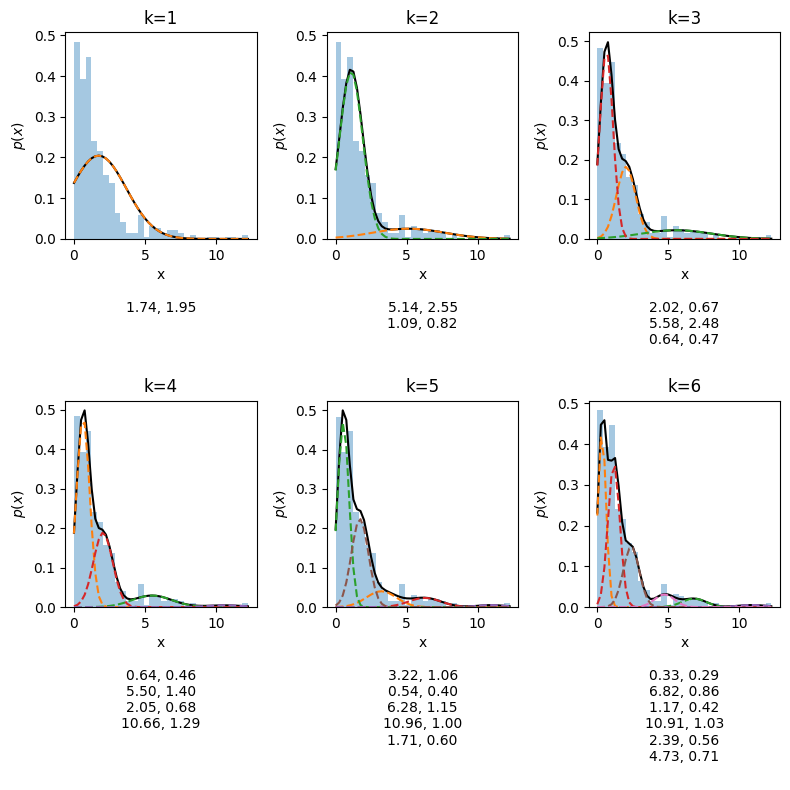

In [ ]:
gmm_deconvolve(df300H.reshape(-1,1))

**AIC BIC values for 0.3um Hardness data**

The chart below indicates that the data likely can be devolved into 3 Gaussian distributions.

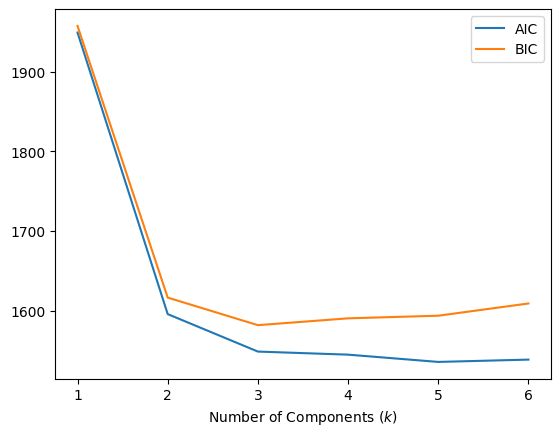

In [ ]:
plot_aic_bic(df300H.reshape(-1,1))

**300 um Elasticity GMM PDF**

min=0.2338, max=108.0135


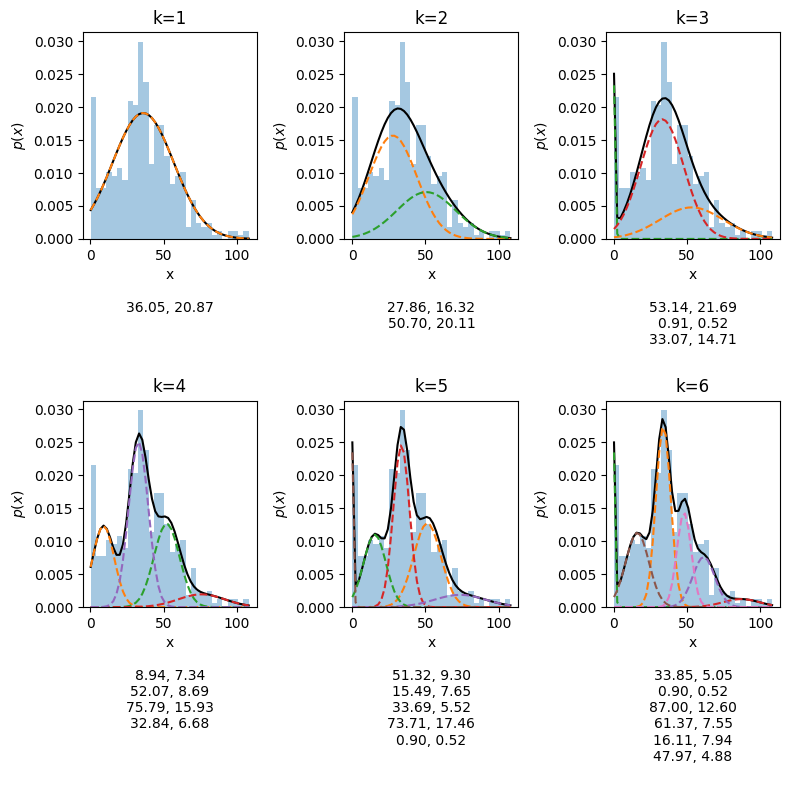

In [ ]:
gmm_deconvolve(df300E.reshape(-1,1))

**AIC BIC values for 0.3um Elasticity data**

The curves are odd-looking. The likeliest numebr of components is 3 in 0.3um Elasticity data.  

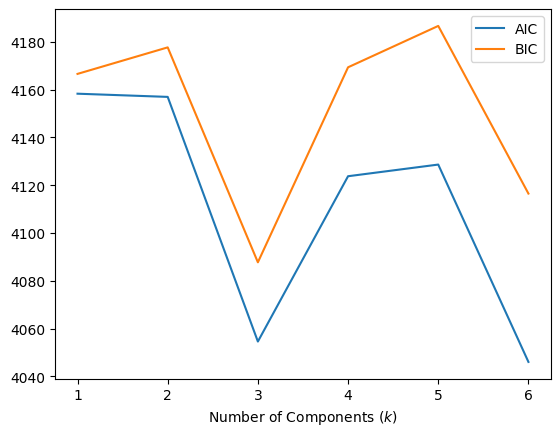

In [ ]:
plot_aic_bic(df300E.reshape(-1,1))

**4um Hardness GMM PDF**

min=0.1961, max=2.2176


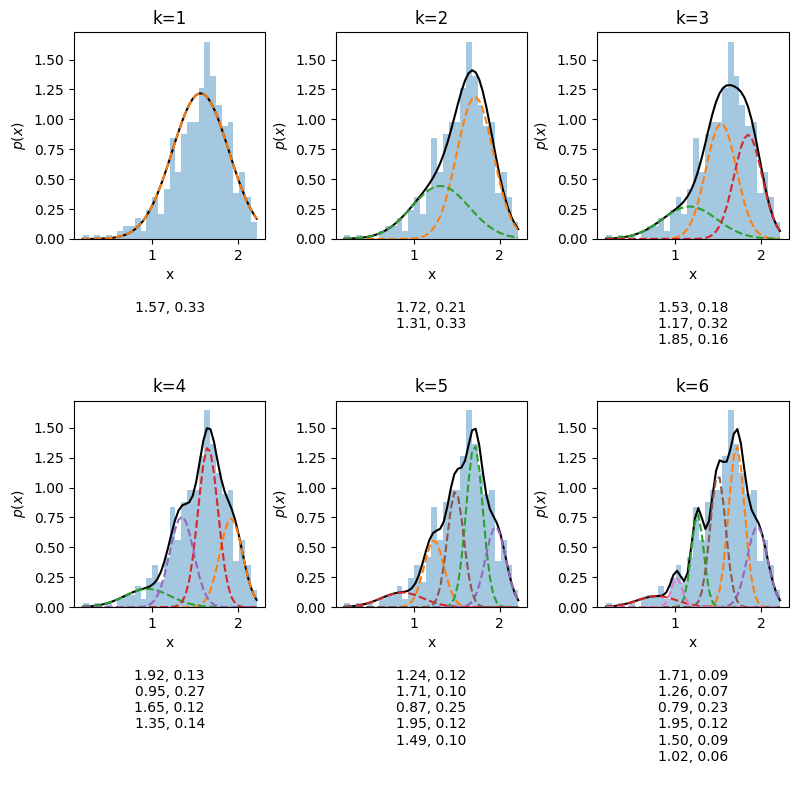

In [ ]:
gmm_deconvolve(df4000H.reshape(-1,1))

**AIC BIC values for 4um Hardness data **

The curves are odd-looking. The likeliest numebr of components is 2 in 4um Elasticity data.

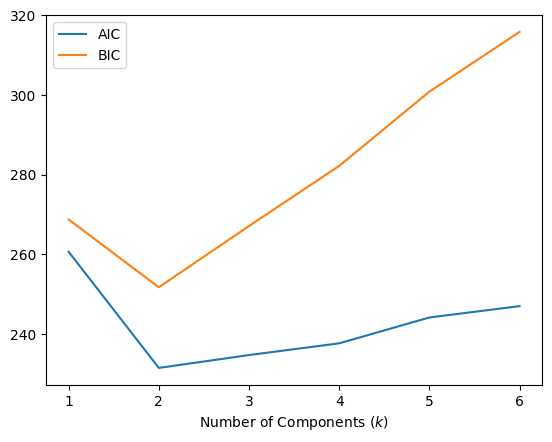

In [ ]:
plot_aic_bic(df4000H.reshape(-1,1))

**4um Elasticity GMM PDF**

min=16.6527, max=50.2018


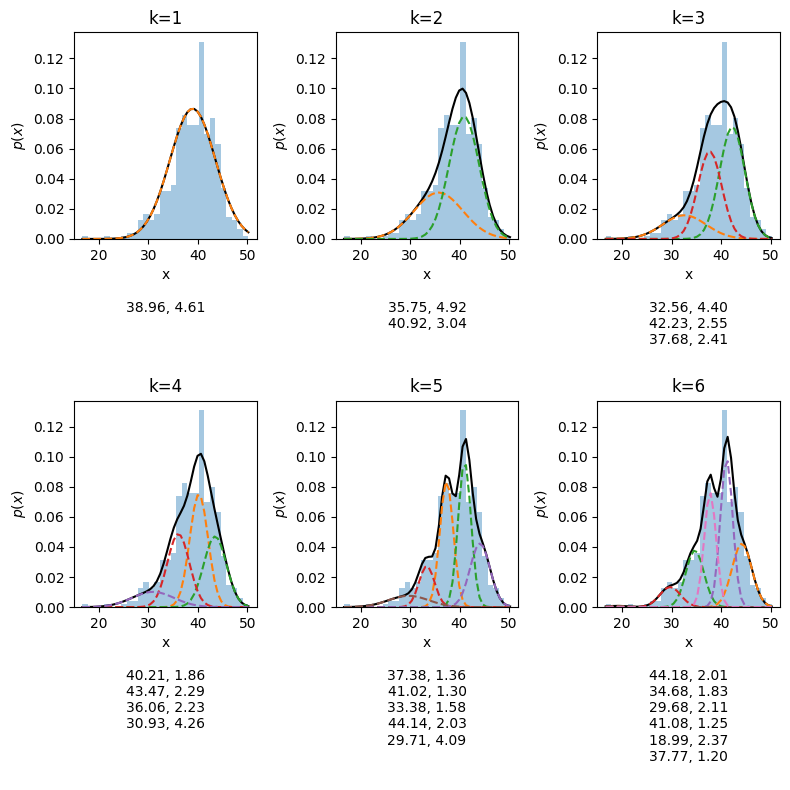

In [ ]:
gmm_deconvolve(df4000E.reshape(-1,1))

**AIC BIC values for 4um Stiffness data**

The curves are odd-looking. The likeliest numebr of components is 2 in 4um Elasticity data.

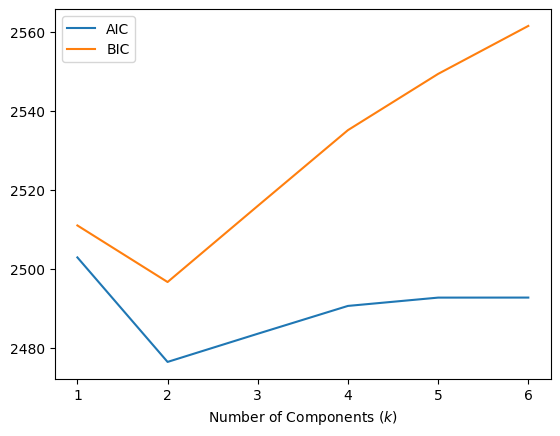

In [ ]:
plot_aic_bic(df4000E.reshape(-1,1))

#2D Analysis

##Elasticity vs. Hardness scatter plot


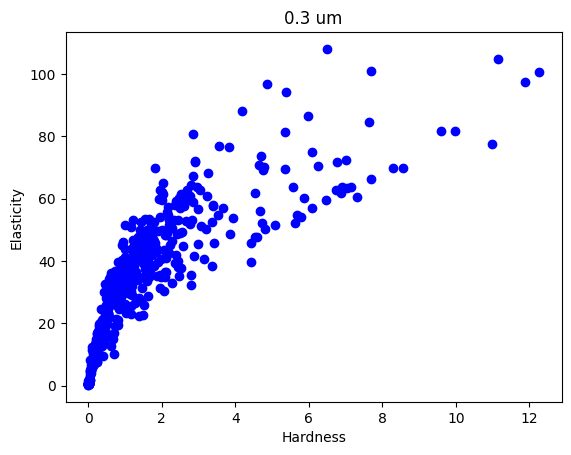

In [ ]:
plt.scatter(df300H, df300E, c ="blue")

plt.title("0.3 um")
plt.ylabel("Elasticity")
plt.xlabel("Hardness")
# To show the plot
plt.show()

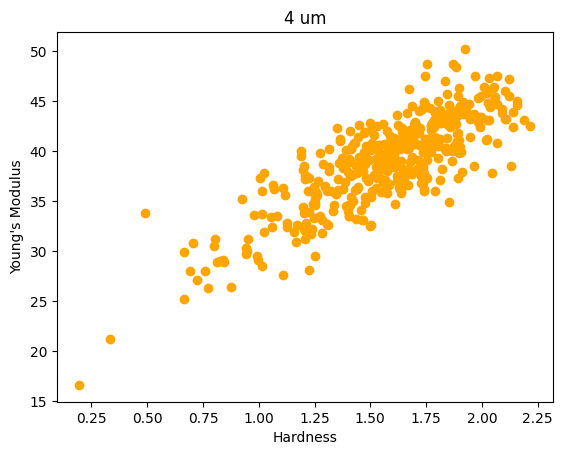

In [ ]:
plt.scatter(df4000H, df4000E, c ="orange")

plt.title("4 um")
plt.ylabel("Young's Modulus")
plt.xlabel("Hardness")
# To show the plot
plt.show()

## K-means

Top 9 algorithms of clustering in machine learning + Proposed Python library and Python code https://medium.com/@mohamadhasan.sarvandani/top-algorithms-of-clustering-in-machine-learning-8e2af2c53d4e


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


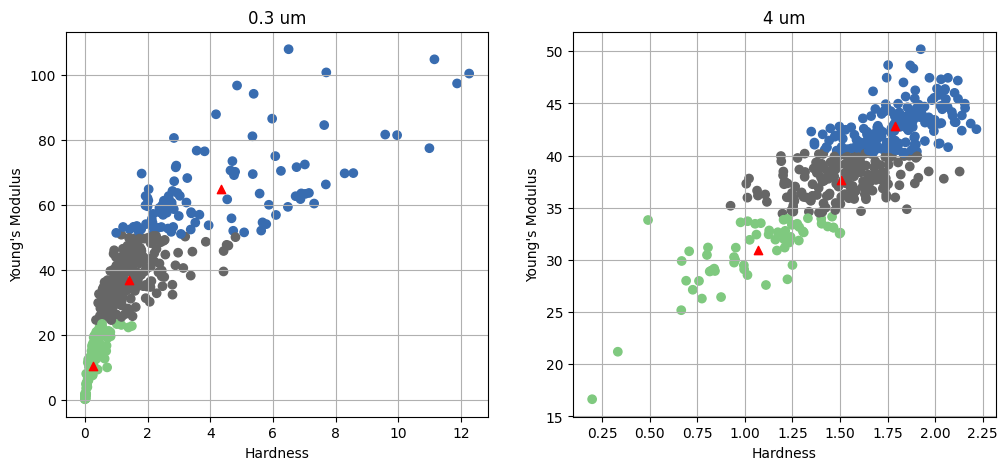

In [ ]:
from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib.cm as cm

he300 = np.vstack((df300H, df300E)).T
#print(f"he300 shape = {he300.shape}")

kmeans = KMeans(n_clusters=3)
km300_pred = kmeans.fit_predict(he300)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.scatter(df300H, df300E, c = km300_pred, cmap=cm.Accent)
plt.title("0.3 um")
plt.grid(True)
for center in kmeans.cluster_centers_:
    center = center[:2]
    plt.scatter(center[0],center[1],marker = '^',c = 'red')
    plt.xlabel("Hardness")
    plt.ylabel("Young's Modulus")


kmeans = KMeans(n_clusters=3)
he4000 = np.vstack((df4000H, df4000E)).T
km4000_pred = kmeans.fit_predict(he4000)
plt.subplot(1,2,2)
plt.scatter(df4000H, df4000E,c = km4000_pred, cmap=cm.Accent)
plt.title("4 um")
plt.grid(True)
for center in kmeans.cluster_centers_:
    center = center[:2]
    plt.scatter(center[0],center[1],marker = '^',c = 'red')
    plt.xlabel("Hardness")
    plt.ylabel("Young's Modulus")
plt.show()

## Hirarchical clustering

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


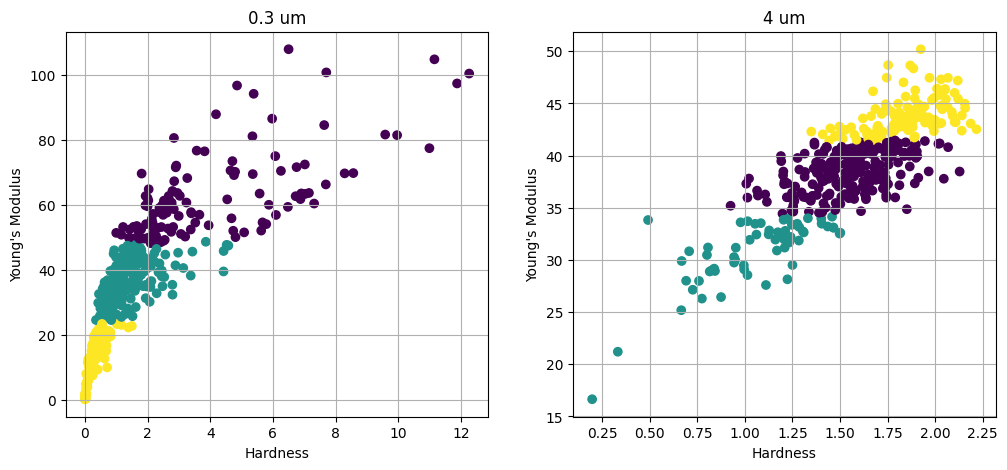

In [ ]:
from sklearn.cluster import AgglomerativeClustering

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)

hierarchical_cluster = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='ward')
labels = hierarchical_cluster.fit_predict(he300)

plt.scatter(df300H.reshape(-1,1), df300E.reshape(-1,1), c=labels)
plt.grid(True)
plt.xlabel("Hardness")
plt.ylabel("Young's Modulus")
plt.title("0.3 um")

plt.subplot(1,2,2)

hierarchical_cluster = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='ward')
labels = hierarchical_cluster.fit_predict(he4000)

plt.scatter(df4000H.reshape(-1,1), df4000E.reshape(-1,1), c=labels)
plt.grid(True)
plt.xlabel("Hardness")
plt.ylabel("Young's Modulus")
plt.title("4 um")

plt.show()

## Gaussian Mixture Model (2D)

function that helps us visualize the locations and shapes of the GMM clusters by drawing ellipses based on the GMM output:

In [ ]:
from matplotlib.patches import Ellipse

def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()

    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)

    # Draw the ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle, **kwargs))

def plot_gmm(gmm, X, label=True, ax=None, title="Title", xlabel='X', ylabel = 'Y'):
    ax = ax or plt.gca()
    labels = gmm.fit(X).predict(X)
    if label:
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)
    else:
        ax.scatter(X[:, 0], X[:, 1], s=40, zorder=2)
    #ax.axis('equal')
    ax.set_xlim(X[:,0].min()-0.10*(X[:,0].min()),X[:,0].max()+0.10*X[:,0].max())
    ax.set_ylim(X[:,1].min()-0.10*(X[:,1].min()),X[:,1].max()+0.10*X[:,1].max())
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    w_factor = 0.2 / gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
        draw_ellipse(pos, covar, alpha=w * w_factor)

<ipython-input-43-d934c09fc07f>:18: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ax.add_patch(Ellipse(position, nsig * width, nsig * height,


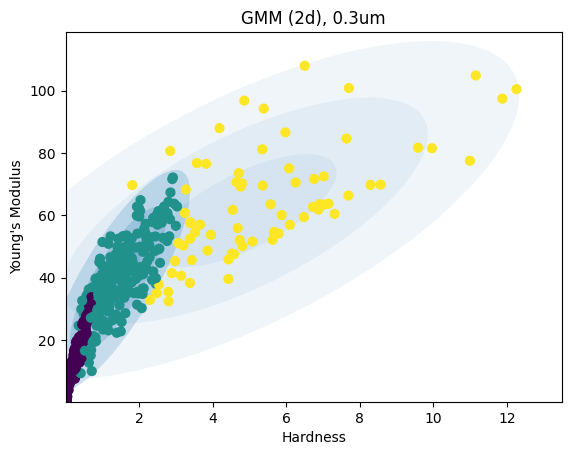

In [ ]:
gmm = GMM(n_components=3, covariance_type='full', random_state=42)

plot_gmm(gmm, he300, title = "GMM (2d), 0.3um", xlabel = "Hardness", ylabel="Young's Modulus")

<ipython-input-43-d934c09fc07f>:18: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ax.add_patch(Ellipse(position, nsig * width, nsig * height,


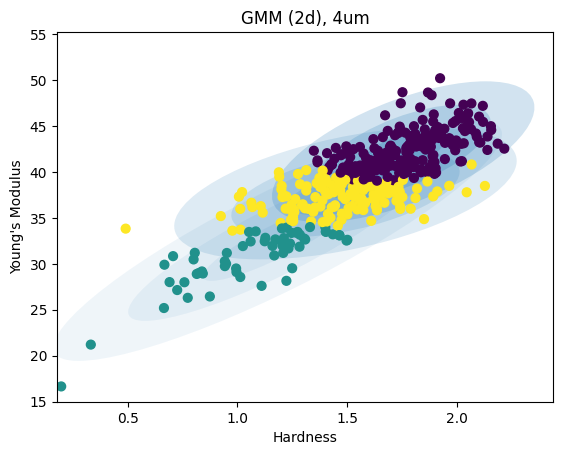

In [ ]:
gmm = GMM(n_components=3, covariance_type='full', random_state=42)
plot_gmm(gmm, he4000, title= "GMM (2d), 4um", xlabel = "Hardness", ylabel="Young's Modulus")

**DBSCAN**

unique_labels:  {0, -1} unique_labels len: 2
['y', 'b', 'g', 'r', 'm', 'c']


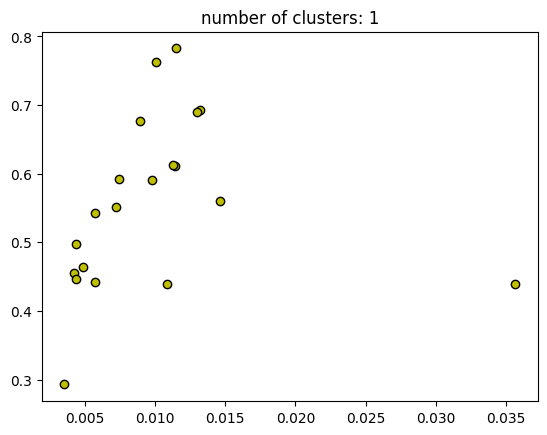

In [ ]:
from sklearn.cluster import DBSCAN
from numpy import unique
from numpy import where

db = DBSCAN(eps=0.25, min_samples=9).fit(he300)

core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

# Plot result

# Black removed and is used for noise instead.
unique_labels = set(labels)
print("unique_labels: ", unique_labels, "unique_labels len:", len(unique_labels))

colors = ['y', 'b', 'g', 'r', 'm', 'c']
print(colors)
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = 'k'

    class_member_mask = (labels == k)

    xy = he300[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=col,
             markeredgecolor='k',
             markersize=6)

plt.title('number of clusters: %d' % n_clusters_)
plt.show()

unique_labels:  {0, 1, 2, 3, 4, 5, 6, 7, -1} unique_labels len: 9
['y', 'b', 'g', 'r', 'm', 'c']


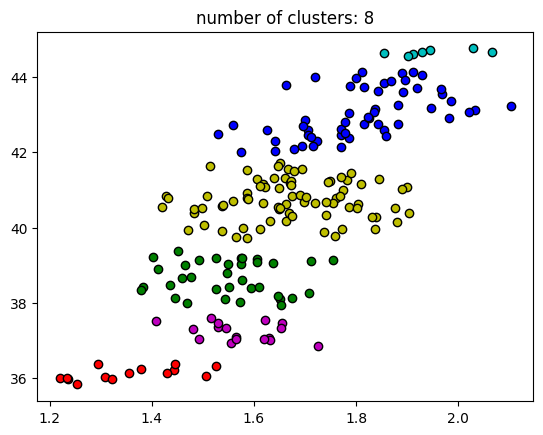

In [ ]:
from sklearn.cluster import DBSCAN
from numpy import unique
from numpy import where

db = DBSCAN(eps=0.25, min_samples=9).fit(he4000)

core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

# Plot result

# Black removed and is used for noise instead.
unique_labels = set(labels)
print("unique_labels: ", unique_labels, "unique_labels len:", len(unique_labels))

colors = ['y', 'b', 'g', 'r', 'm', 'c']
print(colors)
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = 'k'

    class_member_mask = (labels == k)

    xy = he4000[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=col,
             markeredgecolor='k',
             markersize=6)

plt.title('number of clusters: %d' % n_clusters_)
plt.show()

BIRCH

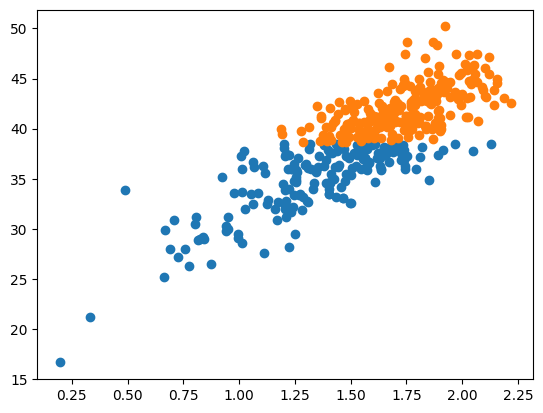

In [ ]:
from sklearn.cluster import Birch

# define the model
birch_model = Birch(threshold=0.03, n_clusters=2)

# train the model
birch_model.fit(he4000)

# assign each data point to a cluster
birch_result = birch_model.predict(he4000)

# get all of the unique clusters
birch_clusters = unique(birch_result)

# plot the BIRCH clusters
for birch_cluster in birch_clusters:
    # get data points that fall in this cluster
    index = where(birch_result == birch_cluster)
    # make the plot
    plt.scatter(he4000[index, 0], he4000[index, 1])

# show the BIRCH plot
plt.show()

# 3D Analysis

## 3D GMM

3D GMM https://www.itzikbs.com/gaussian-mixture-model-gmm-3d-point-cloud-classification-primer
https://github.com/sitzikbs/gmm_tutorial

Understanding Gaussian Mixture Model (GMM) using 1D, 2D, and 3D examples https://www.youtube.com/watch?v=6gUdlygtscI



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cmx
import os

def visualize_3d_gmm(points, w, mu, stdev, export=True):
    '''
    plots points and their corresponding gmm model in 3D
    Input:
        points: N X 3, sampled points
        w: n_gaussians, gmm weights
        mu: 3 X n_gaussians, gmm means
        stdev: 3 X n_gaussians, gmm standard deviation (assuming diagonal covariance matrix)
    Output:
        None
    '''

    n_gaussians = mu.shape[1]
    N = int(np.round(points.shape[0] / n_gaussians))
    print(f"N = {N}")
    # Visualize data
    fig = plt.figure(figsize=(8, 8))
    axes = fig.add_subplot(111, projection='3d')
    #axes.set_xlim([-2, 3])
    #axes.set_ylim([-9, 5])
    #axes.set_zlim([-2, 4])
    axes.set_xlim([-10, 90])
    axes.set_ylim([10, 80])
    axes.set_zlim([0, 120])
    plt.set_cmap('Set1')
    colors = cmx.Set1(np.linspace(0, 1, n_gaussians))
    for i in range(n_gaussians):
        idx = range(i * N, (i + 1) * N)
        axes.scatter(points[idx, 0], points[idx, 1], points[idx, 2], alpha=0.3, c=colors[i])
        plot_sphere(w=w[i], c=mu[:, i], r=stdev[:, i], ax=axes)

    plt.title('3D GMM')
    axes.set_xlabel('Hardness')
    axes.set_ylabel('Elasticity')
    axes.set_zlabel('Stiffness')
    axes.view_init(35.246, 45)
    if export:
        if not os.path.exists('images/'): os.mkdir('images/')
        plt.savefig('images/3D_GMM_demonstration.png', dpi=100, format='png')
    plt.show()


def plot_sphere(w=0, c=[0,0,0], r=[1, 1, 1], subdev=10, ax=None, sigma_multiplier=3):
    '''
        plot a sphere surface
        Input:
            c: 3 elements list, sphere center
            r: 3 element list, sphere original scale in each axis ( allowing to draw elipsoids)
            subdiv: scalar, number of subdivisions (subdivision^2 points sampled on the surface)
            ax: optional pyplot axis object to plot the sphere in.
            sigma_multiplier: sphere additional scale (choosing an std value when plotting gaussians)
        Output:
            ax: pyplot axis object
    '''

    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
    pi = np.pi
    cos = np.cos
    sin = np.sin
    phi, theta = np.mgrid[0.0:pi:complex(0,subdev), 0.0:2.0 * pi:complex(0,subdev)]
    x = sigma_multiplier*r[0] * sin(phi) * cos(theta) + c[0]
    y = sigma_multiplier*r[1] * sin(phi) * sin(theta) + c[1]
    z = sigma_multiplier*r[2] * cos(phi) + c[2]
    cmap = cmx.ScalarMappable()
    cmap.set_cmap('jet')
    c = cmap.to_rgba(w)

    ax.plot_surface(x, y, z, color=c, alpha=0.2, linewidth=1)

    return ax

def visualize_2d_gmm(points, w, mu, stdev, export=True):
    '''
    plots points and their corresponding gmm model in 2D
    Input:
        points: N X 2, sampled points
        w: n_gaussians, gmm weights
        mu: 2 X n_gaussians, gmm means
        stdev: 2 X n_gaussians, gmm standard deviation (assuming diagonal covariance matrix)
    Output:
        None
    '''
    n_gaussians = mu.shape[1]
    N = int(np.round(points.shape[0] / n_gaussians))
    # Visualize data
    fig = plt.figure(figsize=(8, 8))
    axes = plt.gca()
    axes.set_xlim([-1, 1])
    axes.set_ylim([-1, 1])
    plt.set_cmap('Set1')
    colors = cmx.Set1(np.linspace(0, 1, n_gaussians))
    for i in range(n_gaussians):
        idx = range(i * N, (i + 1) * N)
        plt.scatter(points[idx, 0], points[idx, 1], alpha=0.3, c=colors[i])
        for j in range(8):
            axes.add_patch(
                patches.Ellipse(mu[:, i], width=(j+1) * stdev[0, i], height=(j+1) *  stdev[1, i], fill=False, color=[0.0, 0.0, 1.0, 1.0/(0.5*j+1)]))
        plt.title('GMM')
    plt.xlabel('X')
    plt.ylabel('Y')

    if export:
        if not os.path.exists('images/'): os.mkdir('images/')
        plt.savefig('images/2D_GMM_demonstration.png', dpi=100, format='png')

    plt.show()

points type = <class 'numpy.ndarray'>,points shape = (466, 3)
N = 155


<ipython-input-65-a457e60b5e8f>:36: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  axes.scatter(points[idx, 0], points[idx, 1], points[idx, 2], alpha=0.3, c=colors[i])


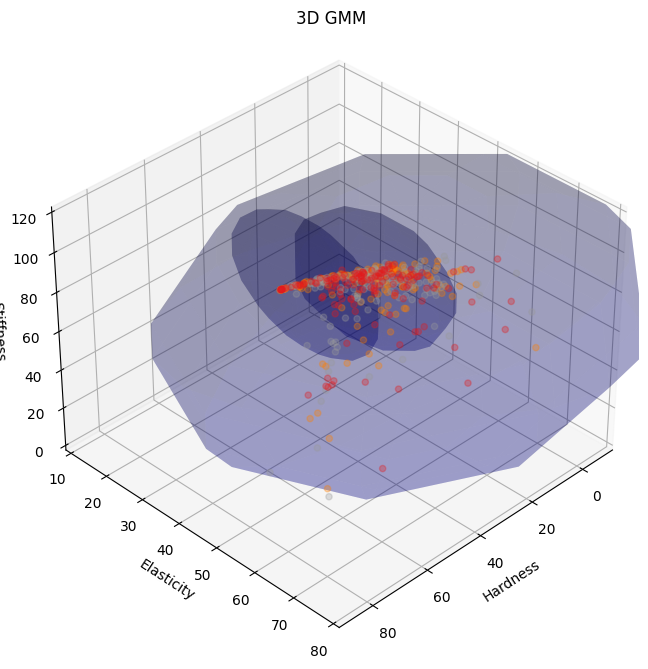

In [ ]:
import numpy as np
#import visualization
from sklearn.mixture import GaussianMixture

## Generate synthetic data
N,D = 148, 3 # number of points and dimenstinality

n_gaussians = 3

points = hes300
print(f"points type = {type(points)},points shape = {points.shape}")

#fit the gaussian model
gmm = GaussianMixture(n_components=n_gaussians, covariance_type='diag')
gmm.fit(points)

#visualize
visualize_3d_gmm(points, gmm.weights_, gmm.means_.T, np.sqrt(gmm.covariances_).T)

N = 155


<ipython-input-65-a457e60b5e8f>:36: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  axes.scatter(points[idx, 0], points[idx, 1], points[idx, 2], alpha=0.3, c=colors[i])


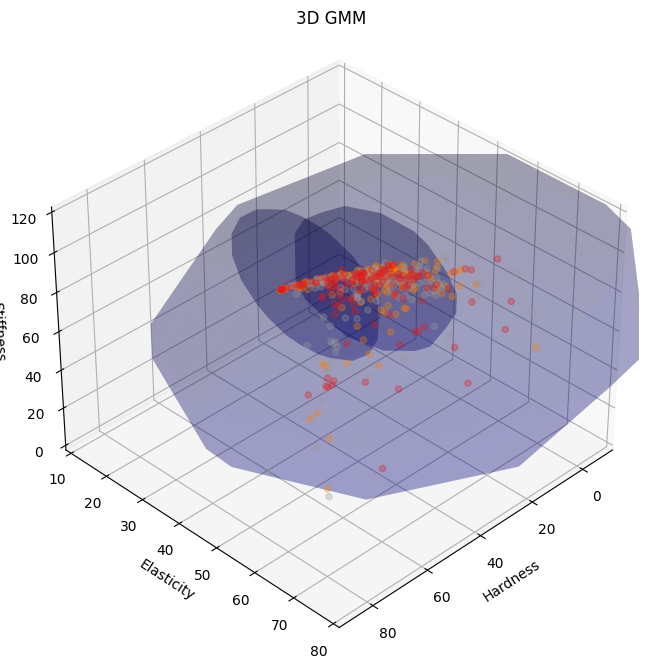

In [ ]:
hes4000 = np.vstack((df4000H*10, df4000E,df4000S/1000)).T
df4000_means = df4000.mean()
normalized_df4000 = (df4000 - df4000_means) / df4000.std()

#fit the gaussian model
gmm = GaussianMixture(n_components=n_gaussians, covariance_type='diag')
gmm.fit(points)

#visualize
visualize_3d_gmm(points, gmm.weights_, gmm.means_.T, np.sqrt(gmm.covariances_).T)